In [1]:
import numpy as np
from numpy.polynomial.chebyshev import chebvander, Chebyshev

def ajuste_chebyshev(x, y, grado):
    """
    Ajuste con polinomios de Chebyshev (primer tipo) usando numpy.

    Parámetros:
    x, y : array_like
        Datos reales.
    grado : int
        Grado del polinomio.

    Retorna:
    coef : array_like
        Coeficientes del polinomio de Chebyshev.
    f_cheb : callable
        Función evaluable del modelo ajustado.
    expresion : str
        Representación simbólica del polinomio ajustado.
    """
    x = np.array(x)
    y = np.array(y)

    # Escalado a [-1, 1] (necesario para Chebyshev)
    x_min, x_max = x.min(), x.max()
    x_scaled = 2 * (x - x_min) / (x_max - x_min) - 1

    # Matriz de diseño con polinomios de Chebyshev
    T = chebvander(x_scaled, grado)
    
    # Resolver el sistema (TᵀT)c = Tᵀy
    coef = np.linalg.solve(T.T @ T, T.T @ y)

    # Crear polinomio de Chebyshev evaluable
    cheb_poly = Chebyshev(coef, domain=[x_min, x_max])  # Define el dominio original

    # Función evaluable
    def f_cheb(x_eval):
        return cheb_poly(x_eval)

    # Construir expresión simbólica
    expresion = "y = " + " + ".join(
        f"{c:.4f} T_{i}(x')" for i, c in enumerate(coef) if abs(c) > 1e-10
    )
    expresion += f"\n(donde x' está normalizado de [{x_min}, {x_max}] a [-1, 1])"

    return coef, f_cheb, expresion

# 🔢 Datos del problema
x = np.array([500, 700, 900, 1100, 1300, 1500, 1700, 1900])
y = np.array([365, 361.6, 370.64, 379.68, 384.46, 395.5, 395.95, 372.91])

# 🧪 Ajuste Chebyshev
grado = 4
coef, f_cheb, expr = ajuste_chebyshev(x, y, grado)

# 📈 Evaluar en los mismos puntos
y_cheb = f_cheb(x)

# 🧮 Calcular error
def error_ajuste(y_real, y_estimado):
    return np.sqrt(np.mean((y_real - y_estimado)**2))

error = error_ajuste(y, y_cheb)

# 📊 Resultados
print("📌 Modelo ajustado (polinomio de Chebyshev):")
print(expr)
print(f"\n✅ Error cuadrático medio (ECM): {error:.4f}")


📌 Modelo ajustado (polinomio de Chebyshev):
y = 377.5378 T_0(x') + 12.9383 T_1(x') + -6.8302 T_2(x') + -8.2486 T_3(x') + -1.8463 T_4(x')
(donde x' está normalizado de [500, 1900] a [-1, 1])

✅ Error cuadrático medio (ECM): 2.0347


In [2]:
import numpy as np

def generar_base_chebyshev(x_norm, grado):
    """
    Genera la matriz de diseño usando polinomios de Chebyshev de primer tipo evaluados en x_norm.
    
    x_norm : array_like
        x escalado a [-1, 1]
    grado : int
        Grado máximo del polinomio de Chebyshev

    Retorna:
    T : ndarray
        Matriz con filas T_0(x), T_1(x), ..., T_grado(x)
    """
    N = len(x_norm)
    T = np.zeros((N, grado + 1))
    T[:, 0] = 1  # T_0(x) = 1
    if grado > 0:
        T[:, 1] = x_norm  # T_1(x) = x
    for n in range(2, grado + 1):
        T[:, n] = 2 * x_norm * T[:, n - 1] - T[:, n - 2]
    return T

def ajuste_chebyshev_manual(x, y, grado):
    """
    Ajuste con polinomios de Chebyshev (implementado manualmente).

    Retorna:
    coef : array_like
        Coeficientes del ajuste en base Chebyshev.
    f_modelo : callable
        Función evaluable.
    expresion : str
        Expresión simbólica del modelo.
    """
    x = np.array(x)
    y = np.array(y)

    # Escalar x a [-1, 1]
    x_min, x_max = x.min(), x.max()
    x_norm = 2 * (x - x_min) / (x_max - x_min) - 1

    # Construir matriz de Chebyshev
    T = generar_base_chebyshev(x_norm, grado)

    # Resolver (TᵀT)a = Tᵀy
    coef = np.linalg.solve(T.T @ T, T.T @ y)

    # Función evaluable
    def f_modelo(x_eval):
        x_eval = np.array(x_eval)
        x_eval_norm = 2 * (x_eval - x_min) / (x_max - x_min) - 1
        T_eval = generar_base_chebyshev(x_eval_norm, grado)
        return T_eval @ coef

    # Expresión simbólica
    expresion = "y = " + " + ".join(
        f"{a:.4f}·T_{i}(x')" for i, a in enumerate(coef) if abs(a) > 1e-10
    )
    expresion += f"\n(donde x' está normalizado de [{x_min}, {x_max}] a [-1, 1])"

    return coef, f_modelo, expresion

# 🧪 Ejemplo de uso
x = np.array([500, 700, 900, 1100, 1300, 1500, 1700, 1900])
y = np.array([365, 361.6, 370.64, 379.68, 384.46, 395.5, 395.95, 372.91])

grado = 4
coef, f_cheb, expr = ajuste_chebyshev_manual(x, y, grado)
y_pred = f_cheb(x)

# Error cuadrático medio
def error_ajuste(y_real, y_pred):
    return np.sqrt(np.mean((y_real - y_pred)**2))

error = error_ajuste(y, y_pred)

# 📊 Resultados
print("📌 Modelo ajustado con Chebyshev (manual):")
print(expr)
print(f"\n✅ Error cuadrático medio (ECM): {error:.4f}")


📌 Modelo ajustado con Chebyshev (manual):
y = 377.5378·T_0(x') + 12.9383·T_1(x') + -6.8302·T_2(x') + -8.2486·T_3(x') + -1.8463·T_4(x')
(donde x' está normalizado de [500, 1900] a [-1, 1])

✅ Error cuadrático medio (ECM): 2.0347


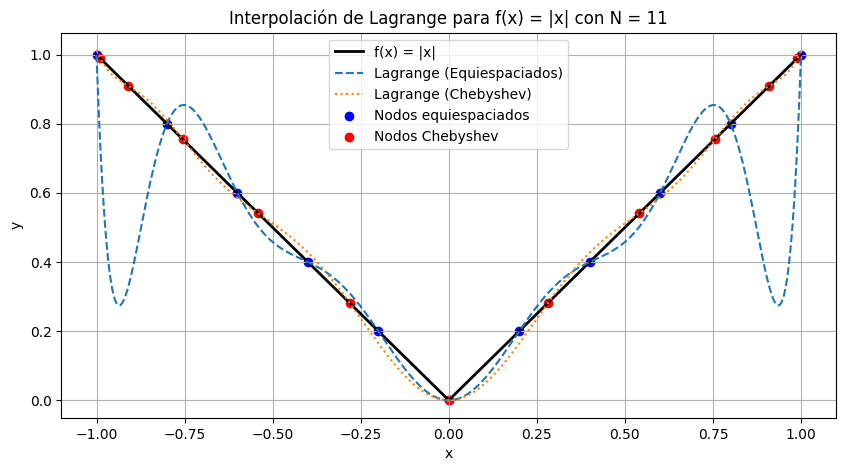

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def f(x):
    """Función objetivo: f(x) = |x|"""
    return np.abs(x)

def generar_nodos_equiespaciados(a, b, n):
    """Genera n nodos equiespaciados en [a, b]."""
    return np.linspace(a, b, n)

def generar_nodos_chebyshev(a, b, n):
    """Genera n nodos de Chebyshev de primer tipo en [a, b]."""
    k = np.arange(1, n + 1)
    x_cheb = np.cos((2 * k - 1) * np.pi / (2 * n))  # en [-1, 1]
    return 0.5 * (b - a) * x_cheb + 0.5 * (b + a)

def lagrange_interpolante(x_nodes, y_nodes, x_eval):
    """
    Interpolación de Lagrange evaluada en x_eval.
    
    x_nodes : array_like
        Nodos de interpolación.
    y_nodes : array_like
        Valores de la función en los nodos.
    x_eval : array_like
        Puntos donde se evalúa el polinomio interpolante.
    """
    n = len(x_nodes)
    x_eval = np.array(x_eval)
    L = np.zeros_like(x_eval, dtype=float)

    for j in range(n):
        lj = np.ones_like(x_eval)
        for m in range(n):
            if m != j:
                lj *= (x_eval - x_nodes[m]) / (x_nodes[j] - x_nodes[m])
        L += y_nodes[j] * lj

    return L

def graficar_interpolacion(a, b, N):
    """
    Grafica f(x) y sus interpolantes de Lagrange usando
    nodos equiespaciados y nodos de Chebyshev.
    """
    # Generar nodos y valores
    x_eq = generar_nodos_equiespaciados(a, b, N)
    y_eq = f(x_eq)
    x_cheb = generar_nodos_chebyshev(a, b, N)
    y_cheb = f(x_cheb)

    # Puntos de evaluación
    x_plot = np.linspace(a, b, 500)
    y_true = f(x_plot)
    y_interp_eq = lagrange_interpolante(x_eq, y_eq, x_plot)
    y_interp_cheb = lagrange_interpolante(x_cheb, y_cheb, x_plot)

    # Graficar
    plt.figure(figsize=(10, 5))
    plt.plot(x_plot, y_true, label="f(x) = |x|", linewidth=2, color='black')
    plt.plot(x_plot, y_interp_eq, '--', label="Lagrange (Equiespaciados)")
    plt.plot(x_plot, y_interp_cheb, ':', label="Lagrange (Chebyshev)")
    plt.scatter(x_eq, y_eq, color='blue', label="Nodos equiespaciados")
    plt.scatter(x_cheb, y_cheb, color='red', label="Nodos Chebyshev")
    plt.title(f"Interpolación de Lagrange para f(x) = |x| con N = {N}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)
    plt.legend()
    plt.show()

# ✅ Ejecutar el ejemplo
if __name__ == "__main__":
    a, b = -1, 1
    N = 11  # Cambia esto para experimentar
    graficar_interpolacion(a, b, N)


In [7]:
def diferencias_divididas_newton(x, y):
    """
    Calcula los coeficientes de la interpolación de Newton
    mediante diferencias divididas.
    """
    n = len(x)
    coef = np.copy(y).astype(float)

    for j in range(1, n):
        coef[j:n] = (coef[j:n] - coef[j-1:n-1]) / (x[j:n] - x[0:n-j])
    
    return coef

def evaluar_newton(x_nodes, coef, x_eval):
    """
    Evalúa el polinomio de Newton usando los coeficientes dados
    y nodos de interpolación.
    """
    n = len(coef)
    x_eval = np.array(x_eval)
    p = np.zeros_like(x_eval, dtype=float)

    for i in range(n - 1, -1, -1):
        p = p * (x_eval - x_nodes[i]) + coef[i]
    
    return p


def graficar_interpolacion(a, b, N, metodo="newton"):
    """
    Grafica f(x) y sus interpolantes usando Lagrange o Newton,
    con nodos equiespaciados y de Chebyshev.
    """
    # Nodos
    x_eq = generar_nodos_equiespaciados(a, b, N)
    y_eq = f(x_eq)
    x_cheb = generar_nodos_chebyshev(a, b, N)
    y_cheb = f(x_cheb)

    x_plot = np.linspace(a, b, 500)
    y_true = f(x_plot)

    if metodo == "lagrange":
        y_interp_eq = lagrange_interpolante(x_eq, y_eq, x_plot)
        y_interp_cheb = lagrange_interpolante(x_cheb, y_cheb, x_plot)
    elif metodo == "newton":
        coef_eq = diferencias_divididas_newton(x_eq, y_eq)
        coef_cheb = diferencias_divididas_newton(x_cheb, y_cheb)
        y_interp_eq = evaluar_newton(x_eq, coef_eq, x_plot)
        y_interp_cheb = evaluar_newton(x_cheb, coef_cheb, x_plot)
    else:
        raise ValueError("Método no reconocido. Usa 'lagrange' o 'newton'.")

    # Graficar
    plt.figure(figsize=(10, 5))
    plt.plot(x_plot, y_true, label="f(x) = |x|", linewidth=2, color='black')
    plt.plot(x_plot, y_interp_eq, '--', label=f"{metodo.capitalize()} (Equiespaciados)")
    plt.plot(x_plot, y_interp_cheb, ':', label=f"{metodo.capitalize()} (Chebyshev)")
    plt.scatter(x_eq, y_eq, color='blue', label="Nodos equiespaciados")
    plt.scatter(x_cheb, y_cheb, color='red', label="Nodos Chebyshev")
    plt.title(f"Interpolación de {metodo.capitalize()} para f(x) = |x| con N = {N}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)
    plt.legend()
    plt.show()


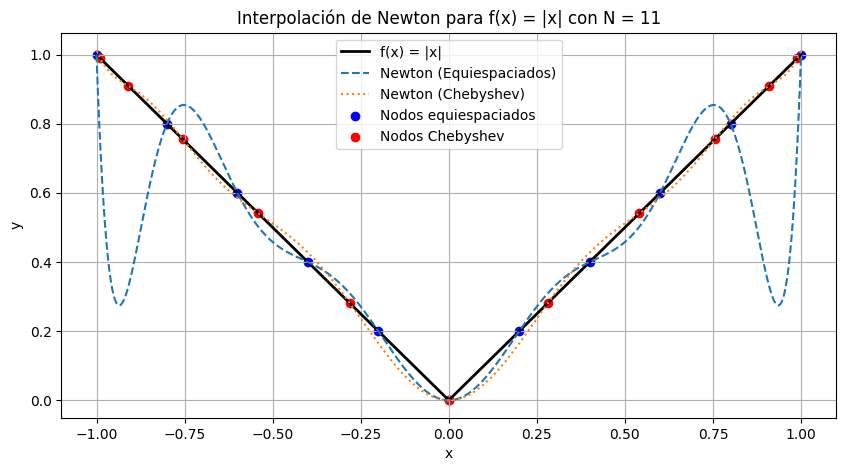

In [8]:
graficar_interpolacion(a, b, N, metodo="newton")
